# Deep Learning with Keras functional API

## Load packages

In [3]:
# libaries to handle warnings
import os
os.environ['MKL_NUM_THREADS'] = '1' #To avoid multithreading.
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# import libraries for reading data, exploring and plotting
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import visualkeras

# library for train test split
from sklearn.model_selection import train_test_split

# Modeling 
import tensorflow
from tensorflow import keras
from tensorflow.keras import models, layers, utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras import models, layers, utils
import tensorflow_recommenders as tfrs
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Input, Reshape, Concatenate
from keras import layers 
from keras.models import Model

## Load Data & Preprocess - Create a subset

As the original dataset is very large with 7.5 Mill entries a subset of 1% due to limited computer power is used for further modeling.

In [4]:
#load training
train = pd.read_csv("train.csv")


In [5]:
# subset
train_p = train.sample(frac=0.01)
train_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75588 entries, 2831496 to 7076603
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   genre_id         75588 non-null  int64
 1   ts_listen        75588 non-null  int64
 2   media_id         75588 non-null  int64
 3   album_id         75588 non-null  int64
 4   context_type     75588 non-null  int64
 5   release_date     75588 non-null  int64
 6   platform_name    75588 non-null  int64
 7   platform_family  75588 non-null  int64
 8   media_duration   75588 non-null  int64
 9   listen_type      75588 non-null  int64
 10  user_gender      75588 non-null  int64
 11  user_id          75588 non-null  int64
 12  artist_id        75588 non-null  int64
 13  user_age         75588 non-null  int64
 14  is_listened      75588 non-null  int64
dtypes: int64(15)
memory usage: 9.2 MB


In [6]:
df1 = pd.DataFrame(train_p, columns=['user_id', 'media_id', "genre_id", "context_type", "is_listened"])

In [7]:
#df1 = df1.sample(frac=1).reset_index(drop=True)
df1.dtypes

user_id         int64
media_id        int64
genre_id        int64
context_type    int64
is_listened     int64
dtype: object

In [14]:
df1.head()

,user_id,media_id,genre_id,context_type,is_listened
320687,2035,4828149,7,3,1
6124982,7445,122171888,0,0,1
6206841,5938,133165774,0,2,1
2263621,589,135092314,0,1,0
706436,2128,3134033,10,0,1


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75588 entries, 2138115 to 1498162
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       75588 non-null  int64
 1   media_id      75588 non-null  int64
 2   genre_id      75588 non-null  int64
 3   context_type  75588 non-null  int64
 4   is_listened   75588 non-null  int64
dtypes: int64(5)
memory usage: 3.5 MB


## Inspect target variable

The target variable is unbalanced. Around 2/3 of the tracks have been "listened" - meaning the user has listened to more than 30 seconds of it (is_listened =1). The remaing 1/3 tracks have not been listened by the users, as they pressd the skip button to change the song before 30 seconds (is_listened = 0). Hence, we have to deal with binary implicit feedback.


In [10]:
df1["is_listened"].value_counts()


1    51514
0    24074
Name: is_listened, dtype: int64

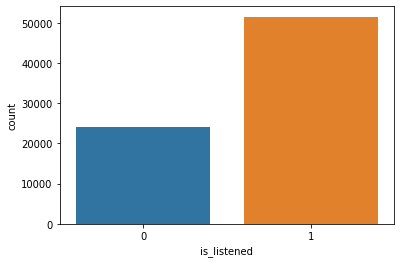

In [13]:
#df1["is_listened"].value_counts().plot()
sns.countplot(x='is_listened', data=df1)
plt.show()

## User and Media ID

From the plot below one can see, that the distribution of user_id is skewed, which means that only a few users use the Deezer App often and remaining users once in a while. Further, the subset data can be regarded rather as sparse: 14378 distinct users have been provided with 30359 tracks, from which 2/3 have been listened longer than 30 seconds.As in the next step a multilayered Neural Network model is created with to embedding layers by using Keras functional API, an encoding of data types has not necessarily to be implemented.  


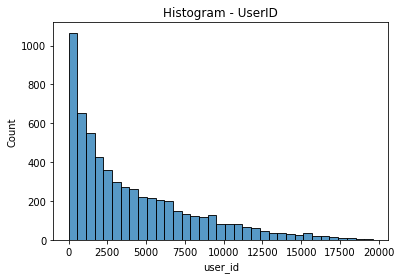

In [32]:
sns.histplot(df1, x="user_id").set(title='Histogram - UserID')
plt.show()

In [59]:
n_media_id = len(df1.media_id.unique())
n_user_id = len(df1.user_id.unique())
print(f'{n_user_id} distinct users have been provided with {n_media_id} tracks, from which 2/3 have been listened longer than 30 seconds')

14378 distinct users have been provided with 30359 tracks, from which 2/3 have been listened longer than 30 seconds


In [60]:
#Which media_id is listened the most often?
ratings = pd.DataFrame(df1.groupby('media_id')['is_listened'].sum().sort_values(ascending=False))
ratings.head(10)

,is_listened
media_id,
133165774,136
132434634,125
132123626,119
132123604,116
132123630,106
132614858,94
134748108,90
131576046,90
132123606,84


In [61]:
# User & tracks grouped by count number of times a song has been listened to by a user
overview = df1.groupby(["user_id", "media_id"])["is_listened"].sum().to_frame("listen_count").reset_index()

In [62]:
# Below own can see the relationship between users and tracks that have been listened less than 30 seconds
print(overview[overview.listen_count == 0].sample(5))

       user_id   media_id  listen_count
37718     2861   78240216             0
24811     1428  131071052             0
19132      959     882290             0
34152     2406  128878480             0
60265     7480  131576046             0


In [63]:
# Below own can see the relationship between users and tracks that have been listened more than 30 seconds
print(overview[overview.listen_count >= 1].sample(5))

       user_id   media_id  listen_count
18472      911  135577766             1
21324     1127   19271771             1
50693     5013   14193948             1
34396     2436    2659940             1
70178    12441  102934830             1


## Context type

The context_type reflects where the song was listened. For example it shows if a song was listened on a playlist or on an album.  This variable is by its natura a highly skewed categorical variable that needs precprocessing. As a functional API with embeeding layers with Keras is approached, for the baseline model a processing is not done, but can if implmented clearly positively inform the model outcome. 

In [9]:
len(df1.context_type.unique())

60

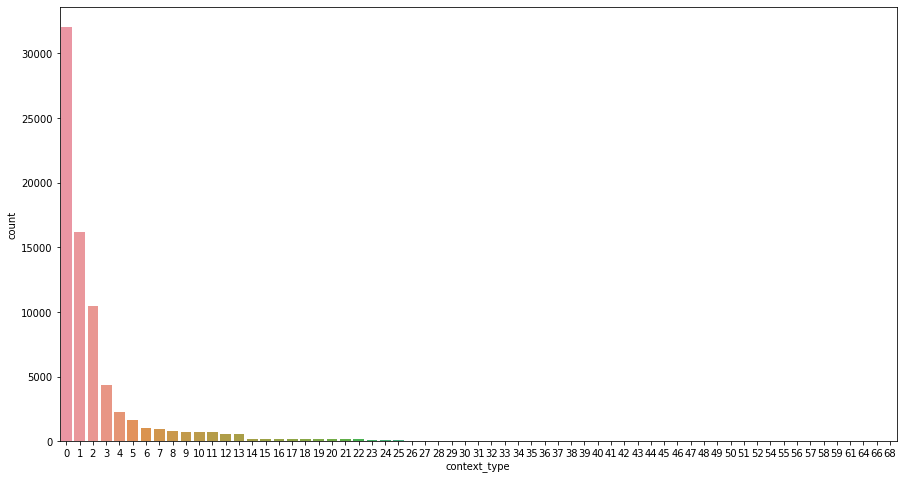

In [9]:
plt.figure(figsize=(15,8))
sns.countplot(x='context_type', data=df1)
plt.show()

In [11]:
df1['context_type'].value_counts()

0     32124
1     16163
2     10534
3      4396
4      2350
5      1687
6       958
7       934
8       785
9       728
10      718
11      651
12      564
13      552
15      221
17      197
18      184
16      183
14      181
19      169
20      158
22      157
21      154
23      135
24      102
25       99
26       71
28       41
27       39
29       39
31       36
30       30
32       28
33       26
38       23
34       22
35       18
37       16
39       16
36       13
40       12
42       11
41       10
43        8
49        6
46        5
48        5
45        4
50        4
62        4
47        3
44        2
51        2
52        2
54        2
55        2
61        1
68        1
57        1
64        1
Name: context_type, dtype: int64

## Split data for training and testing

The data is splittet into 80% for training and 20% for testing.

In [8]:
df = df1
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Models: Deep Learning with Keras functional API 

## Baseline Model 1: Collaborative Filtering 

For modeling this approached use Keras functional API, that is is a way to create models that are more flexible than the sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs - it provides is a way to build graphs of layers. This multi-layer capability of Keras functional API are fruitful for recommender systems as it provides an easy way to build even a recommender model with mixed data types (e.g. combing categorical, numerical, and other data types). 

Another benefit of the functional API in contrast to the sequential API is that one does not necessarily have to encode the input variables. The difference between the two is the fact that an encoder is a predetermined function associating a vector to each data row, while embedding vectors are low dimensional and learned. A neural network learns how to locate objects in an embedding space, placing similar entities close to each other. With its embedding layers this is similar to the matrix factorization, but instead of using a fixed dot-product as recommendation dense layers in the network are used in order to find good combinations. In this baseline model 1 just two embedding layers for the tracks and the user are used. The second model include context_type as an addional variable with an hyprid approach. 

With more computer power additional layers could be added and hyperparameter tuninng performed in order to improve the models. 

In [9]:
# Set size of hidden units and embeeding size
hidden_units = (12,4)
media_embedding_size = 8
user_embedding_size = 8

# Each instance will consist of two inputs: a single user id, and a single movie id
user_id_input = keras.Input(shape=(1,), name='user_id')
media_id_input = keras.Input(shape=(1,), name='media_id')

# Create embedding layers for users and media
user_embedded = keras.layers.Embedding(df1.user_id.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
media_embedded = keras.layers.Embedding(df1.media_id.max()+1, media_embedding_size, 
                                        input_length=1, name='media_embedding')(media_id_input)

# Concatenate the embeddings (and remove the useless extra dimension)
concatenated = keras.layers.Concatenate()([user_embedded, media_embedded])
out = keras.layers.Flatten()(concatenated)

# Add hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# Output layer
out = keras.layers.Dense(1, activation='sigmoid', name='prediction')(out)

# Create the model
model = keras.Model(
    inputs = [user_id_input, media_id_input],
    outputs = out, name="Model_01"
)

# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Show summary
model.summary(line_length=88)

Model: "Model_01"
________________________________________________________________________________________
Layer (type)                 Output Shape       Param #   Connected to                  
user_id (InputLayer)         [(None, 1)]        0                                       
________________________________________________________________________________________
media_id (InputLayer)        [(None, 1)]        0                                       
________________________________________________________________________________________
user_embedding (Embedding)   (None, 1, 8)       157768    user_id[0][0]                 
________________________________________________________________________________________
media_embedding (Embedding)  (None, 1, 8)       109678532 media_id[0][0]                
________________________________________________________________________________________
concatenate (Concatenate)    (None, 1, 16)      0         user_embedding[0][0]          
   

In [47]:
#utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
#keras.utils.plot_model(model, "model_1.png", show_shapes=True)

In [96]:
# Fit the model - First Fit
history = model.fit([train.user_id, train.media_id],
          train.is_listened,
          epochs=15,  batch_size=5000)

Epoch 1/15
13/13 [==============================] - 992s 77s/step - loss: 0.6886 - accuracy: 0.6579
Epoch 2/15
13/13 [==============================] - 1323s 103s/step - loss: 0.6758 - accuracy: 0.6821
Epoch 3/15
13/13 [==============================] - 1086s 84s/step - loss: 0.6611 - accuracy: 0.6821
Epoch 4/15
13/13 [==============================] - 1197s 93s/step - loss: 0.6454 - accuracy: 0.6821
Epoch 5/15
13/13 [==============================] - 1127s 86s/step - loss: 0.6280 - accuracy: 0.6821
Epoch 6/15
13/13 [==============================] - 1210s 94s/step - loss: 0.6080 - accuracy: 0.6821
Epoch 7/15
13/13 [==============================] - 1228s 95s/step - loss: 0.5839 - accuracy: 0.6835
Epoch 8/15
13/13 [==============================] - 1173s 90s/step - loss: 0.5544 - accuracy: 0.7114
Epoch 9/15
13/13 [==============================] - 1093s 82s/step - loss: 0.5219 - accuracy: 0.7734
Epoch 10/15
13/13 [==============================] - 1159s 90s/step - loss: 0.4894 - accura

In [121]:
# Evaluate the 
x = model.evaluate([test.user_id, test.media_id],
          test.is_listened, verbose=True)

473/473 [==============================] - 0s 916us/step - loss: 0.5805 - accuracy: 0.6992


In [110]:
# Save Model
#model.save('Model_Keras_Lek',save_format='tf')
# Save the model - equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
save_model(model, "modelcoll1.hd")

In [10]:
# Predict the collaborative model on a new validation set
df3 = df1
from sklearn.model_selection import train_test_split
train2, test2 = train_test_split(df3, test_size=0.2, random_state=77)



In [11]:
yhat_1 = model.predict([test2.user_id, test2.media_id])
yhat_1

Classification Report
              precision    recall  f1-score   support

           0       0.32      0.26      0.29      4753
           1       0.69      0.75      0.72     10365

    accuracy                           0.60     15118
   macro avg       0.51      0.50      0.50     15118
weighted avg       0.57      0.60      0.58     15118

Accuracy : 0.5967720597962693


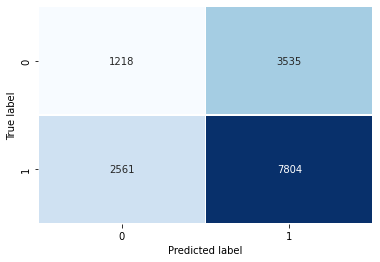

In [15]:
def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')
    
preds = (model.predict([test2.user_id, test2.media_id]) > 0.5).astype("int32")
c_report(test2.is_listened, preds)
plot_confusion_matrix(test2.is_listened, preds)

dict_keys(['loss', 'accuracy'])


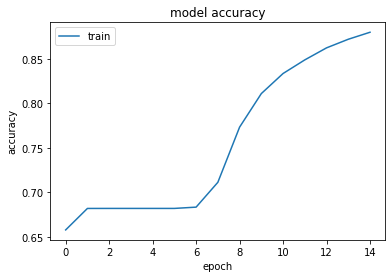

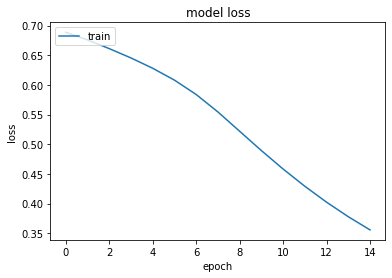

In [101]:
# Visualise training loos and accuracy


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Baseline Model 2: Hybrid

In [9]:
hidden_units = (12,4)
media_embedding_size = 12
user_embedding_size = 12
context_embedding_size = 10
#context_embedding_size = 30

########################################## Neural Network - COLLABORATIVE FILTERING ###################################################
# Input layer

# Create Input layers: Each instance will consist of three inputs: a single user id and a single movie id 
user_id_input = keras.Input(shape=(1,), name='user_id')
media_id_input = keras.Input(shape=(1,), name='media_id')


# Create embedding layers for users, movies and context
user_embedded = keras.layers.Embedding(df1.user_id.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
media_embedded = keras.layers.Embedding(df1.media_id.max()+1, media_embedding_size, 
                                        input_length=1, name='media_embedding')(media_id_input)


# Concatenate the embeddings (and remove the useless extra dimension)
concatenated_a = keras.layers.Concatenate()([user_embedded, media_embedded])
user_media_out = keras.layers.Flatten()(concatenated_a)

# Add hidden layers
for n_hidden in hidden_units:
    user_media_out = keras.layers.Dense(n_hidden, activation='relu')(user_media_out)



########################################## Context Type ###################################################
context = df1[["context_type"]]
ctx = len(context)

#Input Layer
context_input = keras.Input(shape=(1,), name='context_type')
#Embeeding Layer
context_embedded = keras.layers.Embedding(ctx, context_embedding_size, 
                                        input_length=1, name='context_embedding')(context_input)
#Dense Layer
context_x = layers.Dense(name="context_dense", units=ctx, activation='relu')(context_input)


########################################## Hyprid Output  ###################################################
# Merge all
y_out = layers.Concatenate()([user_media_out, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='sigmoid')(y_out)

# Create the model
model = keras.Model(
    inputs = [user_id_input, media_id_input, context_input],
    outputs = y_out, name="Hybrid_Model")


# Complie

#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# --> treshold is 0.5 -> wether the metrics accuracy or binary_arccuracy is taken does not matter as
# Keras convert accuracy into "binary_accuracy" (Source: https://stackoverflow.com/questions/65361359/why-the-accuracy-and-binary-accuracy-in-keras-have-same-result)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "Hybrid_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
media_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 12)        237672      user_id[0][0]                    
__________________________________________________________________________________________________
media_embedding (Embedding)     (None, 1, 12)        1645177932  media_id[0][0]                   
_______________________________________________________________________________________

In [ ]:
#utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
#keras.utils.plot_model(model, "model_1.png", show_shapes=True)

In [16]:
# Fit the hyprid model - First Fit
# Remark: In order to reduce computational power, number of epochs is limited to 15, and batch_size is quite high
# with 50000. This influence the slow decrease in lose and increase in accuracy
history = model.fit([train.user_id, train.media_id, train.context_type],
          train.is_listened,
          epochs=15,  batch_size=5000)

Epoch 1/15
1/1 [==============================] - 137s 137s/step - loss: 0.6459 - accuracy: 0.6942
Epoch 2/15
1/1 [==============================] - 134s 134s/step - loss: 0.6615 - accuracy: 0.6508
Epoch 3/15
1/1 [==============================] - 124s 124s/step - loss: 0.6352 - accuracy: 0.6963
Epoch 4/15
1/1 [==============================] - 137s 137s/step - loss: 0.6161 - accuracy: 0.6963
Epoch 5/15
1/1 [==============================] - 132s 132s/step - loss: 0.6189 - accuracy: 0.6963
Epoch 6/15
1/1 [==============================] - 114s 114s/step - loss: 0.6283 - accuracy: 0.6963
Epoch 7/15
1/1 [==============================] - 119s 119s/step - loss: 0.6338 - accuracy: 0.6963
Epoch 8/15
1/1 [==============================] - 112s 112s/step - loss: 0.6319 - accuracy: 0.6963
Epoch 9/15
1/1 [==============================] - 113s 113s/step - loss: 0.6242 - accuracy: 0.6963
Epoch 10/15
1/1 [==============================] - 121s 121s/step - loss: 0.6157 - accuracy: 0.6963
Epoch 11/

In [17]:
# Evaluate the hyprid model
y = model.evaluate([test.user_id, test.media_id, test.context_type],
          test.is_listened, verbose=True)

#loss, accuracy = model.evaluate([test.user_id, test.media_id, test.context_type], test.is_listened, verbose=True)

4/4 [==============================] - 1s 33ms/step - loss: 0.6958 - accuracy: 0.5950


dict_keys(['loss', 'accuracy'])


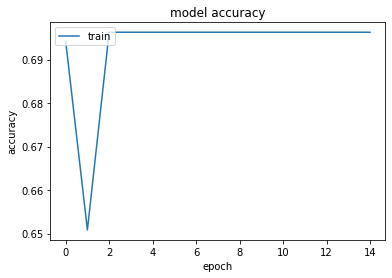

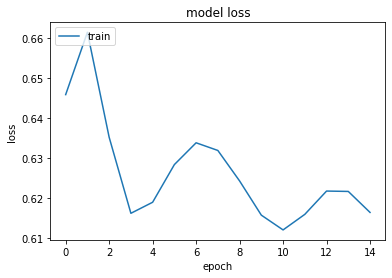

In [18]:
# Visualise training loos and accuracy

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save the model - equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
save_model(model, "modelhyprid1.h5")

In [20]:
# Predict the hyprid model on a new validation set
df4 = df1
from sklearn.model_selection import train_test_split
train3, test3 = train_test_split(df4, test_size=0.2, random_state=99)

yhat_2 = model.predict([test3.user_id, test3.media_id, test3.context_type])

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.71      1.00      0.83        86

    accuracy                           0.71       121
   macro avg       0.36      0.50      0.42       121
weighted avg       0.51      0.71      0.59       121

Accuracy : 0.7107438016528925


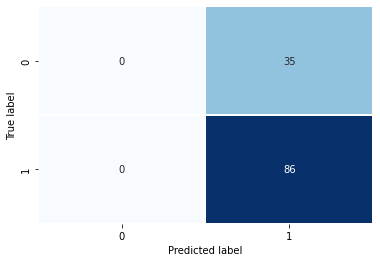

In [26]:
def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')
    
preds = (model.predict([test3.user_id, test3.media_id,test3.context_type]) > 0.5).astype("int32") 

c_report(test3.is_listened, preds)
plot_confusion_matrix(test3.is_listened, preds)

## Comparision and Conclusion

Both baselinemodels could be improved in a number of ways. The outcome of this first models can hardly influence Deezers business in an reliable way. Through variable preprocessing and (auomated) hyperparemetertuning, the models can be improved in the next steps. 